In [4]:
!pip install pydicom nilearn

     |████████████████████████████████| 10.0 MB 129 kB/s 


In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py
import numpy as np
import gzip


/home/seito/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [5]:
def retrieve_paths(directory: str):
	files = os.listdir(directory)
	for fn in files: 
		print(fn)
		file_dir = os.path.join(directory, fn)
		with gzip.open(file_dir,'rb') as zip_ref:
			zip_ref.extractall(os.path.join(file_dir, 'unzip'))


def read_nii(img_path: str): 
	image = nib.load(img_path)
	image = np.asanyarray(image.dataobj)
	image = np.rot90(image)
	return image


In [6]:
folder_name = 'data/BraTS2021_00000'
filenames = sorted(os.listdir(folder_name))
images = []
mask_info = []
for filename in filenames: 
	image = read_nii(os.path.join(folder_name, filename))
	print('{} -- {}'.format(filename, str(image.shape)))
	if 'seg' in filename: 
		# mask of whole tumor
		mask_WT = image.copy()
		mask_WT[mask_WT == 1] = 1
		mask_WT[mask_WT == 2] = 1
		mask_WT[mask_WT == 4] = 1

		# mask of tumor core
		mask_TC = image.copy()
		mask_TC[mask_TC == 1] = 1
		mask_TC[mask_TC == 2] = 0
		mask_TC[mask_TC == 4] = 1

		# mask of enhancing tumor
		mask_ET = image.copy()
		mask_ET[mask_ET == 1] = 0
		mask_ET[mask_ET == 2] = 0
		mask_ET[mask_ET == 4] = 1

		mask_info.append(mask_WT)
		mask_info.append(mask_TC)
		mask_info.append(mask_ET)
	else: 	
		images.append(image)


BraTS2021_00000_flair.nii.gz -- (240, 240, 155)
BraTS2021_00000_seg.nii.gz -- (240, 240, 155)
BraTS2021_00000_t1.nii.gz -- (240, 240, 155)
BraTS2021_00000_t1ce.nii.gz -- (240, 240, 155)
BraTS2021_00000_t2.nii.gz -- (240, 240, 155)


# The structure of 1 dataset instance
* 1 instance contains: 
	* 4 modal: T1, T1CE, T2, and FLAIR
		* each modal is a 3D image, with the size 240x240x155
	* 1 segmentation as label (only for training)
	


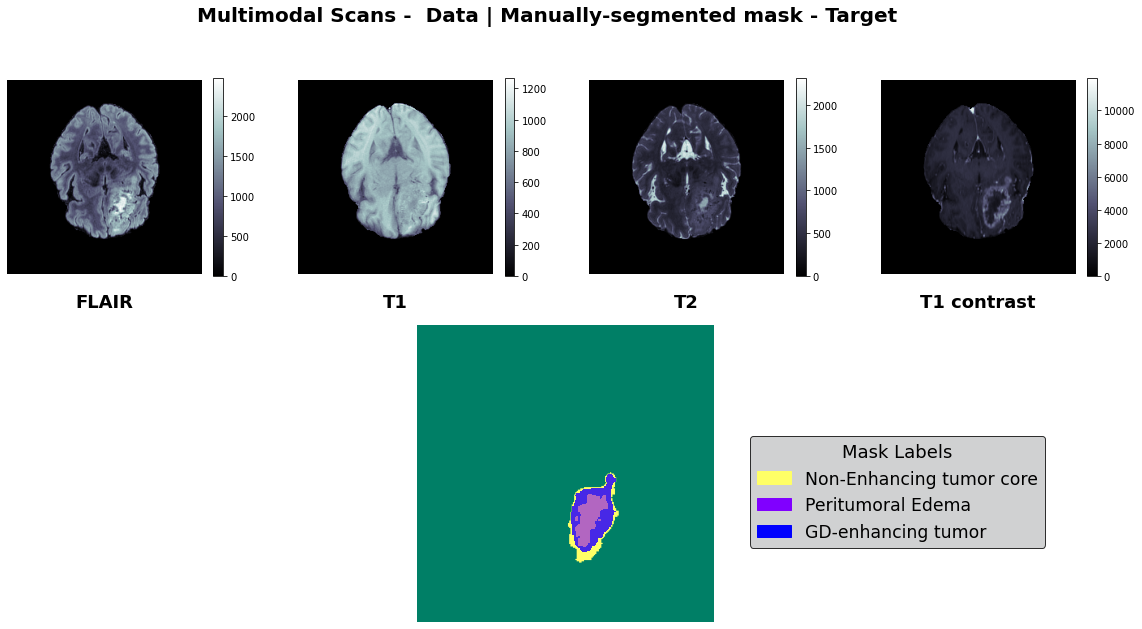

In [75]:

fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(images[0][:, :, 65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(images[1][:, :, 65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(images[3][:, :, 65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(images[2][:, :, 65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
mask_WT, mask_TC, mask_ET = mask_info
l1 = ax4.imshow(mask_WT[:, :, 65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(
    mask_TC[:, :, 65] == False,  mask_TC[:, :, 65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(
    mask_ET[:, :, 65] == False, mask_ET[:, :, 65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0, ax1, ax2, ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1, l2, l3]]
labels = ['Whole tumor',
          'Tumor core ', 'Enhancing tumor']
patches = [mpatches.Patch(
    color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize='xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target",
             fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2,
            transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2,
            transparent=False, bbox_inches='tight')
